# figure 2 vlz

- kernel: r_env, R 4.1.3
- date: 2023-12-27 ~ 12-28

## load

In [1]:
library(tidyverse)
library(tools)
library(logging)
library(ggpubr)
library(ggsci)
library(patchwork)
library(igraph)
library(ggraph)
library(Seurat)
library(maftools)
library(ComplexHeatmap)
library(CellChat)

source('../../stage2/scripts/r_funcs.r')

theme_set(theme_pubr())
logging::basicConfig()
options(warn = -1)

outdir <- '../figures/fig2'
create_dir(outdir)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats

In [ ]:
ctype_ls <- list(
    'Tumor_Gp1' = c("Epi_M_CALML3"),
    'Tumor_Gp2' = c("Epi_M_CPS1", "Epi_M_MYBPC1", "Epi_M_PKP2", "Epi_M_SPRR3", "Epi_M_ACTL8", 'Epi_M_RNASE1'),
    'Epi_Normal' = c("Epi_A_IL1R2", "Epi_A_MGP", "Epi_N_LTF", "Epi_N_PIGR"),
    'Mixture' = c('Epi_T_Mix', 'Epi_B_Mix')
)
epi_gp_order <- c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal', 'Mixture')

f_pat_gp <- '../tables/patient_info.tsv'
gp <- 'response'
gp_lvls$response <- c('R', 'PR')
gp_comp_map$response <- list(
  c('R-pre', 'R-post'),
  c('PR-pre', 'PR-post'),
  c('R-pre', 'PR-pre'),
  c('R-post', 'PR-post')
)
gp_comp_diff_map$response <- list(c('R', 'PR'))
gp_comp_map_pre$response <- list(c('R-pre', 'PR-pre'))
comb_order <- c('R-pre', 'R-post', 'PR-pre', 'PR-post')

gp_lvls$response_v2 <- c('R', 'Gp1-', 'Gp1+', 'PR')
gp_comp_map$response_v2 <- list(
    c('R-pre', 'R-post'),
    c('Gp1+-pre', 'Gp1+-post'),
    c('Gp1--pre', 'Gp1--post'),
    c('R-pre', 'Gp1--pre'),
    c('R-post', 'Gp1--post'),
    c('Gp1+-pre', 'Gp1--pre'),
    c('Gp1+-post', 'Gp1--post'),
    c('R-pre', 'Gp1+-pre'),
    c('R-post', 'Gp1+-post')
)
gp_comp_diff_map$response_v2 <- list(
    c('R', 'Gp1+'),
    c('R', 'Gp1-'),
    c('GP1+', 'Gp1-') 
gp_comp_map_pre$response_v2 <- list(c('R-pre', 'Gp1--pre'),  c('R-pre', 'Gp1+-pre'), c('Gp1+-pre', 'Gp1--pre'))
comb_order_v2 <- c('R-pre', 'R-post', 'Gp1--pre', 'Gp1--post', 'Gp1+-pre', 'Gp1+-post', 'PR-pre')

## 2a-d: immune signature

- TMB: based on T-N paired, fresh, non-LN samples; mutation based on pyclone results (t_alt_count >= 3, t_depth >= 30, autosome mutations), CCF >= 50%
- TNB: sc & wes shared samples, tn-pair, fresh, nonLN samples

### 2a: CCF >= 50%, r vs nr at pre

In [ ]:
f_tmb_ccf <- '../../stage4/a15_wes_clone_infer/new-pyclone/parse/tmb-by_ccf-0.5_1-tn_pair-fresh-t.tsv'
tmb <- read_tsv(f_tmb_ccf, show_col_types = F)
loginfo('%g mutations, %g samples', sum(tmb$n_mut_per_samp_ctype), length(unique(tmb$sample_id)))

2024-02-05 00:04:54 INFO::5529 mutations, 53 samples


In [ ]:
# ccf filtering (>=50% = middle)
tmb_flt <- filter(tmb, ccf_type == 'middle') %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient_id') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

write_tsv(tmb_flt, file = str_glue('{outdir}/fig2-tmb-cff_gt_0.5-tn_pair-fresh-t.tsv'))

loginfo('ccf>=50%%, %g mutations, %g samples', sum(tmb_flt$n_mut_per_samp_ctype), length(unique(tmb_flt$sample_id)))

2024-02-05 00:06:53 INFO::these clinial info will be added: response
2024-02-05 00:06:53 INFO::ccf>=50%, 4053 mutations, 53 samples


In [ ]:
p <- tmb_flt %>% 
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    filter(sample_type == 'pre') %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'n_mut_per_samp_ctype', xorder = paste0(gp_lvls[[gp]], '-pre'),
                      pt_fill = gp, fill_order = gp_lvls[[gp]], pair_by = NULL, facet_by = NULL, xangle = 60) +
    scale_y_continuous(trans = 'log10') +
    stat_compare_means(comparisons = gp_comp_map_pre[[gp]]) +
    labs(fill = '', x = '', y = 'Mutation count (CCF >= 50%)')
ggsave(filename = str_glue('{outdir}/fig2b-box_tmb-ccf_gt_0.5-{gp}-pre-tn_pair-fresh-t.pdf'),
       plot = p, width = 2, height = 5)

### 2b: CCF >= 50%, pre vs post

- 2023-12-28

In [ ]:
# by sample type
p <- read_tsv(file = str_glue('{outdir}/fig2-tmb-cff_gt_0.5-tn_pair-fresh-t.tsv'), show_col_types = F) %>% 
    cell_comp_boxplot(x = 'sample_type', y = 'n_mut_per_samp_ctype', xorder = c('pre', 'post'),
                      pt_fill = 'sample_type', fill_order = c('pre', 'post'), pair_by = 'patient_id',
                      facet_by = NULL, xangle = 60) +
    scale_y_continuous(trans = 'log10') +
    stat_compare_means(comparisons = list(c('pre', 'post'))) +
    scale_fill_manual(values = c('pre' = 'blue', 'post' = 'red')) +
    labs(fill = '', x = '', y = 'Mutation count (CCF >= 50%)') +
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig2c-box_tmb-ccf_gt_0.5-pre_vs_post-tn_pair-fresh-t.pdf'),
       plot = p, width = 2, height = 5)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


### 2c: expression weighted neoantigen with CCF >= 50%

- desc: sc & wes shared samples, tn-pair, fresh, nonLN samples

In [ ]:
f_wt_neo <- '../../stage4/a17_neoantigen/new-neo/analysis/mhc_i-neo_score-ccf-tn_pair-t-sc-exprs.tsv'
samp_clins <- c('patient_id', 'patient', 'treatment_group', 'sample_id', 'sample_type')

df <- read_tsv(f_wt_neo, show_col_types = F) %>% 
    filter(pair_cat == 'Fresh', pair_mode == 'tumor-normal-paired', !grepl('-LN', sample_id)) %>%
    filter(ccf >= 0.5) %>%
    select(all_of(c(samp_clins, 'purity', 'ploidy', 'seq', 'exprs'))) %>%
    distinct() %>%  # same peptide seq but recognized by >=1 HLA is consider only once
    count(pick(c(samp_clins, 'purity', 'ploidy')), name = 'wt_score', wt = .data[['exprs']]) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient_id')


df %>% write_tsv(str_glue('{outdir}/fig2-exprs_wt_tnb-ccf_gt_0.5-tn_pair-fresh-t.tsv'))
loginfo('tn_pair, fresh, nonLN: %g records, %g samples', nrow(df), length(unique(df$sample_id)))

2024-02-05 00:34:27 INFO::these clinial info will be added: response
2024-02-05 00:34:27 INFO::tn_pair, fresh, nonLN: 33 records, 33 samples


In [ ]:
# mandard group at baseline
p <- read_tsv(file = str_glue('{outdir}/fig2-exprs_wt_tnb-ccf_gt_0.5-tn_pair-fresh-t.tsv'), show_col_types = F) %>% 
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    filter(sample_type == 'pre') %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'wt_score', xorder = paste0(gp_lvls[[gp]], '-pre'),
                      pt_fill = gp, fill_order = gp_lvls[[gp]], pair_by = NULL,
                      facet_by = NULL, xangle = 60) +
    scale_y_continuous(trans = 'log10') +
    stat_compare_means(comparisons = gp_comp_map_pre[[gp]]) +
    labs(fill = '', x = '', y = 'Expression-weighted TNB (CCF >= 50%)') +
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig2-box_wt_tnb-ccf_gt_0.5-{gp}-pre-tn_pair-fresh-t.pdf'),
       plot = p, width = 2, height = 5)

### 2d: immune editing score

- desc: tn-pair, fresh, nonLN sample

In [ ]:
f_edit_score <- '../../stage4/a11_wes/new-muts/immune_editing_score.tsv'

df <- read_tsv(f_edit_score, show_col_types = F) %>% 
    filter(!grepl('-LN', sample_id), pair_cat == 'Fresh', pair_mode == 'tumor-normal-paired') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient_id')

df %>% write_tsv(str_glue('{outdir}/fig2-immune_editing_score-tn_pair-fresh-t.tsv'))
loginfo('tn_pair, fresh, nonLN: %g records, %g samples', nrow(df), length(unique(df$sample_id)))

2024-02-05 00:40:55 INFO::these clinial info will be added: response
2024-02-05 00:40:55 INFO::tn_pair, fresh, nonLN: 53 records, 53 samples


In [ ]:
# pre vs post
p <- df %>% 
    cell_comp_boxplot(x = c('sample_type'), y = 'editing_score', pt_fill = 'sample_type', pair_by = 'patient_id',
                      fill_order = c('pre', 'post'), facet_by = NULL, xorder = c('pre', 'post'), xangle = 60) +
    stat_compare_means(comparisons = list(c('pre', 'post')))+
    labs(fill = '', y = 'Immune editing score') + 
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig2e-box_edit_score-pre_vs_post-tn_pair-fresh-t.pdf'),
       plot = p, width = 2, height = 4.5)

## 2e: cell compostion for tumor/Normal Epi, min50 result

In [ ]:
f_cc <- '../figures/fig2/fig2i-cell_comp-ek_hk.tsv'
min_cell <- 50

In [ ]:
df <- read_tsv(file = f_cc, show_col_types = F) %>% 
    mutate(cellgp = if_else(cell_type %in% c('Tumor_Gp1', 'Tumor_Gp2'), 'Tumor_Gp1/2', cell_type)) %>% 
    summarise(.by = c('patient', 'patient_id', 'response', 'sample_type', 'cellgp', 'n_cell_per_sample_ctype'),
             freq = sum(freq)) %>% 
    mutate(pct = 100 * freq / n_cell_per_sample_ctype)
df %>% write_tsv(str_glue('{outdir}/figs3b-epi-tumor_normal_cc.tsv'))

In [ ]:
# for all samples
p <- read_tsv(str_glue('{outdir}/figs3b-epi-tumor_normal_cc.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    filter(cellgp %in% c('Tumor_Gp1/2', 'Epi_Normal')) %>%
    mutate(cellgp = factor(cellgp, c('Tumor_Gp1/2', 'Epi_Normal'))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = 'cellgp',
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent in Epi', fill = 'Response')
ggsave(filename = str_glue('{outdir}/figs3b-box_cc_in_epi-tumor_normal-all.pdf'), plot = p, width = 7, height = 5.5)

# filter out samples without enough cells
p <- read_tsv(str_glue('{outdir}/figs3b-epi-tumor_normal_cc.tsv'), show_col_types = F) %>% 
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    filter(!is.na(.data[[gp]])) %>%
    filter(cellgp %in% c('Tumor_Gp1/2', 'Epi_Normal')) %>%
    mutate(cellgp = factor(cellgp, c('Tumor_Gp1/2', 'Epi_Normal'))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = 'cellgp',
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent in Epi', fill = 'Response')
ggsave(filename = str_glue('{outdir}/figs3b-box_cc_in_epi-macrotype-tumor_normal-min{min_cell}.pdf'), plot = p, width = 7, height = 5.5)

## 2f: heatmap of cluster vs patient/sample: min50 result

In [ ]:
f_epi_obs <- '../../stage4/a01_data/h5ad/epi_obs.csv'
min_cell <- 50  # min cell per group

In [ ]:
# detail & macro celltype map
celltype_map <- do.call(
    rbind.data.frame, 
    lapply(X = names(ctype_ls), FUN = function(nm) {
        data.frame(macrotype = nm, celltype = ctype_ls[[nm]])
    })
)

# color map
macrotype_color_map <- pal_nejm()(length(unique(celltype_map$macrotype)))
names(macrotype_color_map) <- unique(celltype_map$macrotype)

# data: cell level
df <- read_csv(f_epi_obs, show_col_types = F)

New names:
• `` -> `...1`


In [ ]:
# by patient
cal_by <- 'patient'
all_cal_types <- unique(df[[cal_by]])
highconf_cal_types <- count(df, .data[[cal_by]]) %>%
    filter(n >= min_cell) %>%
    pull(.data[[cal_by]])
loginfo('%g/%g %s with enough cells', length(highconf_cal_types), length(all_cal_types), cal_by)

# plot data
mat <- df %>% 
    count(.data[[cal_by]], cell_type, name = 'freq') %>% 
    pivot_wider(id_cols = c('cell_type'), names_from = .data[[cal_by]],
                values_from = 'freq', values_fill = 0) %>% 
    mutate(across(all_of(all_cal_types), ~ 100*.x/sum(.x))) %>%
    column_to_rownames('cell_type')
mat <- mat[intersect(pull(celltype_map, 'celltype'), rownames(mat)), ]

# plot
for (suf in c('all', str_glue('min{min_cell}'))) {
    if (suf == 'all') {
        dp <- mat
    } else {
        dp <- mat[, highconf_cal_types]
    }
    set.seed(123)
    row_anno <- rowAnnotation(
        'Epithelial\ncell groups' = pull(celltype_map, 'macrotype', name = 'celltype')[rownames(mat)],
        col = list('Epithelial\ncell groups' = macrotype_color_map),
        show_annotation_name = c('Epithelial\ncell groups' = FALSE), 
        width = unit(1, 'cm'), na_col = 'gray50',
        annotation_legend_param = list('Epithelial\ncell groups' = list(
            at = names(macrotype_color_map), labels = names(macrotype_color_map)
        ))
    )
    treat_heatmap(
        mat = dp, cluster_columns = F, cluster_rows = F, name = str_glue('Percent \nin {cal_by}'),
        row_names_gp = gpar(fontsize = 9), right_annotation = row_anno, fig_size = c(7, 2), 
        outfile = str_glue('{outdir}/fig2g-heat-macro_pct_in_{cal_by}-{suf}.pdf')
    )
}

2024-02-05 01:25:53 INFO::51/52 patient with enough cells


## 2g: marker dotplot

In [ ]:
f_epi_obj <- '../../stage4/a01_data/seuobj/epi.rds'

scrna <- readRDS(f_epi_obj)
scrna$macro_celltype <- 'Others'
for (nm in names(ctype_ls)) {
    scrna$macro_celltype[scrna$cell_type %in% ctype_ls[[nm]]] <- nm
}
scrna$macro_celltype <- factor(scrna$macro_celltype, levels = epi_gp_order)
table(scrna$macro_celltype, useNA = 'ifany')


 Tumor_Gp1  Tumor_Gp2 Epi_Normal    Mixture 
     35838      18407      12952       7843 

In [ ]:
# no Mixture cells
Idents(scrna) <- scrna$macro_celltype
subdata <- subset(scrna, idents = 'Mixture', invert = TRUE)
table(Idents(subdata), useNA = 'ifany')


 Tumor_Gp1  Tumor_Gp2 Epi_Normal 
     35838      18407      12952 

In [ ]:
# manual selected markers based on top10 markers
ctype_lvl <- intersect(names(ctype_ls), unique(scrna$macro_celltype))
markers <- list(
    'Epi' = c('EPCAM', 'KRT14', 'KRT15'),
    'Epi Develop' = c('KRT6B', 'LGALS7B', 'KRT16', 'LY6D', 'TP63', 'LAMB3'),
    # 'Antigen' = c('CTSD', 'HLA−DRA', 'HLA−DRB1', 'HLA−DRB5', 'HLA-DQA1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQB1'),
    'Immune Repress' = c('CD74', 'PTGES', 'S100P', 'RUNX3', 'TGFB1', 'CEACAM1', 'OAS1', 'HLA-E', 'CTSD'),
    'Apoptosis Repress' = c('MUC1', 'PTGS2', 'PINK1', 'BCL2L1', 'SOD2', 'CCT3', 'PARP1')
)
subdata$macro_celltype <- factor(subdata$macro_celltype, levels = ctype_lvl)
p <- DotPlot(subdata, features = markers, group.by = 'macro_celltype') +
    scale_color_gsea() +
    guides(color = guide_colorbar(title.position = 'top'),
           size = guide_legend(title.position = 'top')) +
    labs(x = '', y = '', color = 'Average Expression', size = 'Percent Expressed') +
    theme(axis.text.x = element_text(angle = 60, hjust = 0.95, vjust = 0.95),
          legend.position = 'top', legend.title.align = 0.5,
          legend.justification = 0.5, legend.key.width = unit(1, 'cm'))
ggsave(filename = str_glue('{outdir}/fig2h-dot_epi_marker-noMixture.pdf'), plot = p, width = 9, height = 4)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


## 2h: macrotype by response: min50 result

In [ ]:
f_epi_obs <- '../../stage4/a01_data/h5ad/epi_obs.csv'
f_whole_obs <- '../../stage4/a01_data/h5ad/whole_obs.csv'
min_cell <- 50

In [ ]:
# calculate cell composition
df_samp <- read_csv(f_whole_obs, show_col_types = F) %>% 
    count(sample, name = 'n_cell_samp')
df <- read_csv(f_epi_obs, show_col_types = F) %>%
    rename(cell_type_prev = cell_type)
df$cell_type <- df$cell_type_prev
for (nm in names(ctype_ls)) {
    df$cell_type[df$cell_type_prev %in% ctype_ls[[nm]]] <- nm
}
table(df$cell_type_prev, df$cell_type)

df <- cal_cell_comp(df_info = df, samp_cnt = df_samp, clinical_cols = 'patient') %>% 
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = c('patient_id', gp), merge_by = 'patient') %>%
    add_count(sample, name = 'n_cell_per_sample_ctype', wt = freq)  # count cell for each subtype each sample
df %>% write_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'))

New names:
• `` -> `...1`
New names:
• `` -> `...1`


              
               Epi_Normal Mixture Tumor_Gp1 Tumor_Gp2
  Epi_A_IL1R2        5726       0         0         0
  Epi_A_MGP          2452       0         0         0
  Epi_B_Mix             0     775         0         0
  Epi_M_ACTL8           0       0         0       942
  Epi_M_CALML3          0       0     35838         0
  Epi_M_CPS1            0       0         0      7715
  Epi_M_MYBPC1          0       0         0      4075
  Epi_M_PKP2            0       0         0      1411
  Epi_M_RNASE1          0       0         0      1719
  Epi_M_SPRR3           0       0         0      2545
  Epi_N_LTF            38       0         0         0
  Epi_N_PIGR         4736       0         0         0
  Epi_T_Mix             0    7068         0         0

2024-02-05 02:49:55 INFO::these clinial info will be added: patient_id, response


In [ ]:
# for all samples
p <- read_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    filter(cell_type %in% c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal')) %>%
    mutate(cell_type = factor(cell_type, c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal'))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent in Epi', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig2i-box_cc_in_epi-macrotype-{gp}-all.pdf'), plot = p, width = 7, height = 5.5)

# filter out samples without enough cells
p <- read_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'), show_col_types = F) %>% 
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    filter(!is.na(.data[[gp]])) %>%
    filter(cell_type %in% c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal')) %>%
    mutate(cell_type = factor(cell_type, c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal'))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent in Epi', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig2i-box_cc_in_epi-macrotype-{gp}-min{min_cell}.pdf'), plot = p, width = 7, height = 5.5)

## 2i: scatter of TMB (CCF>=50%) vs EK percent in Epi: all result

In [ ]:
f_ek_cc <- '../figures/fig2/fig2i-cell_comp-ek_hk.tsv'
f_ccf_info <- '../figures/fig2/fig2-tmb-cff_gt_0.5-tn_pair-fresh-t.tsv'
min_cell <- 50

In [ ]:
# countruct data
df <- read_tsv(f_ek_cc, show_col_types = F) %>% 
    filter(cell_type == 'Tumor_Gp1') %>% 
    select(patient_id, sample_type, n_cell_per_sample_ctype, ek_pct_in_epi = pct) 
df <- read_tsv(f_ccf_info, show_col_types = F) %>% 
    merge(df, by = c('patient_id', 'sample_type'))
df %>% write_tsv(str_glue('{outdir}/fig2k-ek_pct-vs-tmb-ccf_gt_0.5-tn_pair-fresh-t.tsv'))
loginfo('%g samples', length(unique(df$sample_id)))

2024-02-23 20:23:52 INFO::35 samples


In [ ]:
df %>% filter(n_cell_per_sample_ctype < 50)

patient_id,sample_type,response,sample_id,mandard_group,response_degree,patient_gp,patient_gp_v2,n_mut_per_samp,ccf_type,n_mut_per_samp_ctype,n_mut_norm,n_cell_per_sample_ctype,ek_pct_in_epi
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
041,post,PR,03-041-T,poor,mild,pEKD,pEKD,15,middle,14,0.9333333,1,0
051,post,R,03-051-T,good,severe,good,good,10,middle,6,0.6000000,2,0


In [ ]:
for (suf in c('all', str_glue('min{min_cell}'))) {
    if (suf == 'all') {
        dp <- df
    } else {
        dp <- filter(df, n_cell_per_sample_ctype >= min_cell)
    }
    loginfo('%s: %g samples', suf, length(unique(dp$sample_id)))
    p <- ggscatter(data = dp, x = 'ek_pct_in_epi', y = 'n_mut_per_samp_ctype', conf.int = TRUE,
                   add = 'reg.line', add.params = list(color = "blue", fill = 'lightgray'), 
                   cor.coef = TRUE, cor.coeff.args = list(method = "pearson")) +
        scale_y_log10() + 
        labs(x = 'Percent of Tumor_Gp1 cells in Epi', y = 'Mutation count (CCF>=50%)')
    ggsave(filename = str_glue('{outdir}/fig2k-scatter-ek_pct-vs-tmb_ccf_gt_0.5-tn_pair-fresh-t-{suf}.pdf'),
           plot = p, width = 4, height = 4)
}

2024-02-23 20:24:20 INFO::all: 35 samples
2024-02-23 20:24:21 INFO::min50: 33 samples


## 2k: survival plot by zhaoren !!!

## 2j: immune related cell communication

- desc: only T cells relevant pairs; T cells as target (exclude Epi_normal/mixture); use sample by sample results

In [ ]:
f_full <- '../../stage4/a21_cell_comm/ek_hk_major/analysis/v2-interactions-with_clin-full.tsv'
f_interset <- '../../stage4/a21_cell_comm/immune_related_lg_cellchat_merge.tsv'
ctype_color <- c(
    'B & Plasma' = '#e71818', 'Tumor_Gp1' = '#317dbd', 'Endothelial' = '#46ae46',
    'Fibroblast' = '#9c4da5', 'Tumor_Gp2' = '#f79600', 'Myeloid' = '#f782bd', 'T cells' = '#bd9ece'
)

min_cell <- 50  # ligand/receptor should expressed in min_cell source/target cells
min_sample_num <- 3  # interaction should detected in these samples intra sample group
thresh <- 0.05  # significant threshold

### preprocess

In [ ]:
# all results  
df_raw <- read_tsv(f_full, show_col_types = F) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'),
           response = case_match(mandard_group, 'good' ~ 'R', 'poor' ~ 'PR')) %>% 
    select(-c('mandard_group')) %>%
    mutate(source = case_match(source, 'EK_tumor' ~ 'Tumor_Gp1', 'HK_tumor' ~ 'Tumor_Gp2', .default = source),
           target = case_match(target, 'EK_tumor' ~ 'Tumor_Gp1', 'HK_tumor' ~ 'Tumor_Gp2', .default = target))
loginfo('total %g interactions, %g samples', nrow(df_raw), length(unique(df_raw$sample)))

# interested cell-cell interactions
df_comm <- read_tsv(f_interset, show_col_types = F) %>% 
    filter(gene_type == 'receptor') %>% 
    select(interaction_name, immune_direction) %>% 
    distinct() 
loginfo('%g intersted interactions', nrow(df_comm))

2024-03-04 15:00:26 INFO::total 251965 interactions, 81 samples
2024-03-04 15:00:26 INFO::65 intersted interactions


In [ ]:
# only T cells relevant L-R pairs
df <- df_raw %>% 
    filter(target == 'T cells',
           !source %in% c('Epi_Norm', 'Epi_Others'))
loginfo('%g T cells relevant pairs, %g samples', nrow(df), length(unique(df$sample)))

# filter by cell number
df <- df %>% 
    filter(n_cell_receptor_in_target_max >= min_cell, 
           n_cell_ligand_in_source_max >= min_cell)
loginfo('filter by cell number >= %g: %g records, %g samples',
        min_cell, nrow(df), length(unique(df$sample)))

# only intersted interactions
df <- merge(df, df_comm, by = 'interaction_name')
loginfo('only intersted interactions: %g records, %g samples', nrow(df), length(unique(df$sample)))

# only samples with clinical info
df_flt <- df %>% 
    filter(.data[[gp]] %in% gp_lvls[[gp]])
loginfo('samples with %s info: %g pairs, %g samples', gp, nrow(df_flt), length(unique(df_flt$sample)))

# filter by sample number
df_flt <- df_flt %>% 
    add_count(.data[[gp]], sample_type, source, target, interaction_name, name = 'n_sample') %>% 
    filter(n_sample >= min_sample_num)
loginfo('filter by sample number >= %g: %g records, %g samples',
        min_sample_num, nrow(df_flt), length(unique(df_flt$sample)))

# filter in-significant interactions
df_flt <- df_flt %>%
    summarise(.by = c(gp, 'sample_type', 'source', 'target', 'interaction_name'),
              p_min = min(pval)) %>%
    filter(p_min <= thresh) %>%
    select(.data[[gp]], sample_type, source, target, interaction_name) %>%
    merge(df_flt, by = c(gp, 'sample_type', 'source', 'target', 'interaction_name'))
loginfo('filter out interactions all insignificant intra sample group: %g records, %g samples',
        nrow(df_flt), length(unique(df_flt$sample)))

2024-03-04 15:00:30 INFO::16885 T cells relevant pairs, 81 samples
2024-03-04 15:00:30 INFO::filter by cell number >= 50: 14965 records, 81 samples
2024-03-04 15:00:30 INFO::only intersted interactions: 996 records, 73 samples
2024-03-04 15:00:30 INFO::samples with response info: 799 pairs, 62 samples
2024-03-04 15:00:30 INFO::filter by sample number >= 3: 707 records, 62 samples
2024-03-04 15:00:30 INFO::filter out interactions all insignificant intra sample group: 707 records, 62 samples


In [ ]:
# init node info
df_node <- data.frame(name = sort(unique(c(df_flt$source, df_flt$target))))
df_node$node_color <- NA
for (nm in names(ctype_color)) {
    df_node$node_color[df_node$name == nm] <- ctype_color[nm]
}

# init edges
df_edge <- df_flt %>% 
    summarise(.by = c(.data[[gp]], sample_type, 'source', 'target', 'interaction_name', 'immune_direction'),
              prob_agg = mean(prob)) %>%  # summarise for samples of each interaction
    add_count(.data[[gp]], sample_type, source, target, immune_direction, name = 'n_interaction') %>% 
    summarise(.by = c(gp, 'sample_type', 'source', 'target', 'n_interaction', 'immune_direction'),
              prob_mean = mean(prob_agg),
              prob_med = median(prob_agg)) # summarise for interaction 
# add edge color (color by source)
df_edge <- df_node %>% 
    select(source = name, edge_color = node_color) %>% 
    merge(df_edge, by = 'source') %>% 
    select(source, target, edge_color, n_interaction, prob_mean, prob_med, .data[[gp]], sample_type, immune_direction)

df_node %>% write_tsv(str_glue('{outdir}/figs3d-t_immune-node.tsv'))
df_edge %>% write_tsv(str_glue('{outdir}/figs3d-t_immune-edge.tsv'))

### vlz

In [ ]:
coords <- as.matrix(data.frame(
    c(1.0000000, -0.2225209, -0.9009689, -0.9009689, -0.2225209, 0.6234898, 0.6234898),
    c(0.0000000, -0.9749279, 0.4338837, -0.4338837, 0.9749279, 0.7818315, -0.7818315)
))

In [ ]:
# weight by prob
weight_by <- 'prob_mean'
jp_opt(wd=14, hg = 6, res = 200)
pdf(file = str_glue('{outdir}/figs3d-t_immune-prob.pdf'), width = 14, height = 6)
par(mfrow = c(2, 4), mar = c(1.5, 0, 1.5, 0.5))
for (d in unique(df_edge$immune_direction)) {
    for (stype in c('pre', 'post')) {
        for (my_gp in gp_lvls[[gp]]) {
            dp_edge <- filter(df_edge, .data[[gp]] == my_gp, sample_type == stype, immune_direction == d)
            if (nrow(dp_edge) == 0) {
                plot.new()
                next
            }
            # plot
            net <- graph_from_data_frame(d = dp_edge, vertices = df_node, directed = T)
            plot(net, 
                 edge.arrow.size = 0.5, 
                 edge.curved = 0.4,
                 edge.color = E(net)$edge_color,
                 edge.width = get.edge.attribute(net, weight_by) * 300,
                 edge.label = round(get.edge.attribute(net, weight_by) * 100, 1),
                 edge.label.cex = 1,
                 vertex.size = 30,
                 vertex.color = V(net)$node_color,
                 vertex.label.color = "black",
                 vertex.label.cex = 1,
                 layout = coords,
                 main = str_glue('T cells {d} incoming signals in {my_gp}-{stype}'))
        }
    }
}
dev.off()

png 
  2

## 2l: EK tumor in response v2 (PR to GP1+/- and other PR)

min 50 Epi cells per sample

In [ ]:
min_cell <- 50
df <- read_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'), show_col_types = F) %>% 
    filter(cell_type == 'Tumor_Gp1')
df %>% dim

[1] 81 11

In [ ]:
# redefine patient group
cc_diff <- df %>% 
    pivot_wider(id_cols = c('patient', gp), names_from = 'sample_type', values_from = 'pct') %>% 
    filter(!is.na(pre), !is.na(post)) %>%  # remove unpaired patients
    mutate(diff = post - pre)
cc_diff %>% dim

pat_pEKI <- filter(cc_diff, .data[[gp]] == 'PR', diff > 0) %>% pull(patient)  # patients whose EK tumor increased after treat
pat_pEKD <- filter(cc_diff, .data[[gp]] == 'PR', diff < 0) %>% pull(patient)  # patients whose EK tumor decreased after treat

df_gp <- read_tsv(f_pat_gp, show_col_types = F) %>% 
    mutate(response_v2 = case_when(
        patient %in% pat_pEKD ~ 'Gp1-',
        patient %in% pat_pEKI ~ 'Gp1+',
        TRUE ~ .data[[gp]]
    ))
# update clin info
df_gp %>% write_tsv('../tables/patient_info_v2.tsv')
table(df_gp[[gp]], df_gp$response_v2, useNA = 'ifany')
# update cell composition
df <- add_clin_info(df = df, ftsv = '../tables/patient_info_v2.tsv', columns = 'response_v2', merge_by = 'patient')
df %>% write_tsv(str_glue('{outdir}/fig2m-cell_comp-ek.tsv'))

[1] 29  5

      
       Gp1- Gp1+ PR  R <NA>
  PR      8    5  6  0    0
  R       0    0  0 32    0
  <NA>    0    0  0  0   19

2024-02-05 21:54:47 INFO::these clinial info will be added: response_v2


In [ ]:
# for all samples
curr_gp <- 'response_v2'
p <- read_tsv(str_glue('{outdir}/fig2m-cell_comp-ek.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[curr_gp]])) %>%
    cell_comp_boxplot(x = c(curr_gp, 'sample_type'), y = 'pct', facet_by = NULL, pt_fill = curr_gp,
                      xorder = comb_order_v2, fill_order = gp_lvls[[curr_gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[curr_gp]]) +
    labs(y = 'Percent of Tumor_Gp1 cells in Epi', fill = 'Detailed\nresponse') +
    theme(legend.position = 'right')
ggsave(filename = str_glue('{outdir}/fig2m-box_cc_in_epi-macrotype-{curr_gp}-all.pdf'), plot = p, width = 5, height = 6)

# filter out samples without enough cells
p <- read_tsv(str_glue('{outdir}/fig2m-cell_comp-ek.tsv'), show_col_types = F) %>% 
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    filter(!is.na(.data[[curr_gp]])) %>%
    cell_comp_boxplot(x = c(curr_gp, 'sample_type'), y = 'pct', facet_by = NULL, pt_fill = curr_gp,
                      xorder = comb_order_v2, fill_order = gp_lvls[[curr_gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[curr_gp]]) +
    labs(y = 'Percent of Tumor_Gp1 cells in Epi', fill = 'Detailed\nresponse') +
    theme(legend.position = 'right')
ggsave(filename = str_glue('{outdir}/fig2m-box_cc_in_epi-macrotype-{curr_gp}-min{min_cell}.pdf'), plot = p, width = 5, height = 6)

## 2m: Treg expaned percent boxplot: min10 result

- percent in T cells (RNA & TCR data), n_cell_per_sample_subtype >= 10, by response-v2
- 2024-02-27: now is fig2m

In [ ]:
f_expand <- '../../stage4/a03_tcr/expansion/expand_cell_pct.csv'
f_pat_gp_v2 <- '../tables/patient_info_v2.tsv'
min_cell <- 10
valid_types <- c('Treg_LTB', 'Treg_TNFRSF4')

df <- read_csv(file = f_expand, show_col_types = F) %>%
    filter(subtype %in% valid_types) %>%
    mutate(sample = paste(patient, sample_type, sep = '-')) %>%
    select(sample, sample_type, patient, subtype, n_expand_cell_per_sample_stype, n_cell_per_sample_subtype, pct_by_subtype) %>%
    add_clin_info(ftsv = f_pat_gp_v2, columns = NULL, merge_by = 'patient') %>%
    mutate(macrotype = 'Treg') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))
loginfo('Treg: %g records, %g samples', nrow(df), length(unique(df$sample)))

write_tsv(x = df, file = str_glue('{outdir}/fig2n-Treg_expand_percet-by_subtype.tsv'))

2024-02-05 03:10:19 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2, response, response_v2
2024-02-05 03:10:19 INFO::Treg: 160 records, 81 samples


In [ ]:
df %>% filter(n_cell_per_sample_subtype < 10) %>% count(sample, response_v2)

sample,response_v2,n
<chr>,<chr>,<int>
P01-Treat,R,2
P13-Treat,Gp1-,1
P25-Treat,R,1
P43-Treat,R,2
P46-Treat,R,2
P51-Treat,R,1


In [ ]:
# response v2, subtype
curr_gp <- 'response_v2'
for (suf in c('all', str_glue('min{min_cell}'))){
    if (suf != 'all') {
        dp <- df
    } else {
        dp <- filter(df, n_cell_per_sample_subtype >= 10)
    }
    loginfo('%s: %g samples', suf, length(unique(dp$sample)))
    p <- dp %>% 
        filter(.data[[curr_gp]] %in% gp_lvls[[curr_gp]]) %>%
        cell_comp_boxplot(x = c(curr_gp, 'sample_type'),  y = 'pct_by_subtype', pt_fill = curr_gp, facet_by = 'subtype', 
                          xorder = comb_order_v2, fill_order = gp_lvls[[curr_gp]], ncol = 7, wrap_free = 'free',
                          xangle = 60, ytitle = 'Expanded cell percent') + 
        labs(fill = 'Detailed response') +
        stat_compare_means(comparisons = gp_comp_map[[curr_gp]]) 
    ggsave(filename = str_glue('{outdir}/fig2n-box_expand_in_subtype-detail-{curr_gp}-{suf}.pdf'), plot = p, width = 5, height = 6)
}

2024-02-05 03:11:25 INFO::all: 76 samples
2024-02-05 03:11:26 INFO::min10: 81 samples


## 2n-0: virus cell percent

- date: 2024-02-27

### 2n: pct in all cells, R-pre vs PR-pre 

In [ ]:
f_obs <- '../../stage4/a24_microbe/domain_lvl/whole_obs_with_domain_logrpm.rds'
min_cell <- 50
cutoff <- 0

In [ ]:
df <- readRDS(f_obs) %>% 
    mutate(bi_type = case_when(
        is.na(Viruses) ~ NA_character_,
        Viruses > cutoff ~ 'Virus-detected',
        Viruses <= cutoff ~ 'Non-detected',
        TRUE ~ 'others'
    )) %>%
    count(sample, bi_type, name = 'n_cell') %>%
    add_count(sample, wt = n_cell, name = 'n_cell_per_sample') %>%
    filter(n_cell_per_sample >= min_cell) %>%
    mutate(pct = 100 * n_cell / n_cell_per_sample) %>%
    pivot_wider(id_cols = c('sample'), 
                names_from = 'bi_type', values_from = 'pct', values_fill = 0) %>%
    separate(col = 'sample', into = c('patient', 'sample_type'), sep = '-', remove = F) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
loginfo('%g records', nrow(df))
df %>% write_tsv(str_glue('{outdir}/fig2n-virus_detection_in_whole-bi-sample_lvl-pct.tsv'))

2024-02-27 14:29:42 INFO::these clinial info will be added: response
2024-02-27 14:29:42 INFO::81 records


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig2n-virus_detection_in_whole-bi-sample_lvl-pct.tsv'), show_col_types = F) %>% 
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    filter(sample_type == 'pre') %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'Virus-detected', pt_fill = gp, pair_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], facet_by = NULL, ncol = 3) +
    stat_compare_means(comparisons = list(c('R-pre', 'PR-pre'))) +
    labs(y = 'Percent of virus-detected cells', fill = 'Response') +
    theme(axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/fig2n-box_cell_pct-virus_detected_cells-whole.pdf'), width = 3, height = 6, plot = p)

### 2o: pct in tumor Gp1/2 cells, Gp1 vs Gp2

In [ ]:
f_obs <- '../../stage4/a24_microbe/domain_lvl/whole_obs_with_domain_logrpm.rds'
min_cell <- 50
cutoff <- 0

used_ctypes <- c('Tumor_Gp1', 'Tumor_Gp2')

In [ ]:
# rename cell type
df <- readRDS(f_obs) %>% 
    filter(cell_type == 'Epithelial')

df$celltype <- df$subtype
for (nm in names(ctype_ls)) {
    df$celltype[df$subtype %in% ctype_ls[[nm]]] <- nm
}
# stat percent in each cluster
df_stat <- df %>% 
    mutate(bi_type = case_when(
        is.na(Viruses) ~ NA_character_,
        Viruses > cutoff ~ 'Virus-detected',
        Viruses <= cutoff ~ 'Non-detected',
        TRUE ~ 'others'
    )) %>%
    count(sample, celltype, bi_type, name = 'n_cell') %>%
    add_count(sample, celltype, wt = n_cell, name = 'n_cell_per_sample_ctype') %>%
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    mutate(pct = 100 * n_cell / n_cell_per_sample_ctype) %>%
    pivot_wider(id_cols = c('sample', 'celltype'), 
                names_from = 'bi_type', values_from = 'pct', values_fill = 0) %>%
    separate(col = 'sample', into = c('patient', 'sample_type'), sep = '-', remove = F) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df_stat %>% write_tsv(str_glue('{outdir}/fig2o-virus_detection_in_epi_group-bi-sample_lvl-pct.tsv'))

2024-02-27 14:47:01 INFO::these clinial info will be added: response


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig2o-virus_detection_in_epi_group-bi-sample_lvl-pct.tsv'), show_col_types = F) %>% 
    filter(celltype %in% c('Tumor_Gp1', 'Tumor_Gp2')) %>%
    mutate(celltype = factor(celltype, names(ctype_ls))) %>%
    cell_comp_boxplot(x = c('celltype'), y = 'Virus-detected', pt_fill = gp,
                      pair_by = NULL, facet_by = NULL, ncol = 3, xangle = 60,
                      xorder = names(ctype_ls), fill_order = gp_lvls[[gp]]) +
    stat_compare_means(comparisons = list(c('Tumor_Gp1', 'Tumor_Gp2'))) +
    labs(y = 'Percent of virus-detected cells', fill = 'Response') +
    theme(axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/fig2o-box_cell_pct-virus_detected_cells-gp1_vs_gp2.pdf'), width = 3, height = 6, plot = p)

# previous results

## oncoplot of drive genes: 2a

- based on T-N paired, Fresh, non-LN samples (N=53)
- 2024-01-02: add new genes

In [20]:
f_maf <- '../../stage4/a11_wes/new-muts/vep_maf_with_clin_ek_info.rds'
f_pub_drive <- '../../assets/escc_key_alt_genes.tsv'
f_escc_drive_infer <- '../../stage4/a11_wes/new-muts/driver_gene-tn_pair-fresh-t.tsv'

clin_color_map <- list(
    'Response' = c(R='#EE0000FF', PR='#3B4992FF'),
    'Sample_Type' = c(pre='#5050FFFF', post='#CE3D32FF'),
    'Treatment' = c(chemo='#749B58FF', `chemo+immune`='#F0E685FF')
)

add_genes <- c(
    'B2M', 'HLA-A', 'HLA-B', 'HLA-C',  # interseted genes
    'HLA-DRB1', 'HLA-DQB1', 'HLA-DQA2', 'HLA-DOB'  # other HLA genes detected in current data
)

In [56]:
maf <- readRDS(file = f_maf)

In [57]:
maf_raw <- maf

In [58]:
maf@clinical.data <- getClinicalData(maf) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = 'response', merge_by = 'patient_id') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    mutate(
        'Response' = factor(response, gp_lvls$response),
        'Sample_Type' = factor(sample_type, c('pre', 'post')),
        'Treatment' = factor(treatment_sum, c('chemo', 'chemo+immune'))
    ) %>% 
    data.table::as.data.table()

2024-02-04 23:49:11 INFO::these clinial info will be added: response


In [59]:
# obtain driver genes
driver_genes <- read_tsv(f_pub_drive, show_col_types = F) %>% 
    pull(gene)
driver_genes <- read_tsv(f_escc_drive_infer, show_col_types = F) %>% 
    filter(!grepl('^MT-', Hugo_Symbol)) %>%  # no chrM genes
    filter(fdr <= 0.1) %>% 
    pull(Hugo_Symbol) %>% 
    c(driver_genes)
driver_genes <- unique(c(driver_genes, add_genes))

length(driver_genes)

[1] 36

In [60]:
# only tn-pair, fresh, samples
samples <- getClinicalData(maf) %>%
    filter(pair_cat == 'Fresh', pair_mode == 'tumor-normal-paired', !grepl('-LN', Tumor_Sample_Barcode)) %>%
    pull(Tumor_Sample_Barcode)
length(samples)
submaf <- subsetMaf(maf, tsb = samples)
saveRDS(submaf, str_glue('{outdir}/maf-tn_pair-fresh-t.rds'))

[1] 53

--Possible FLAGS among top ten genes:
  TTN
  MUC16
-Processing clinical data


In [61]:
# plot
pdf(file = str_glue('{outdir}/fig2a-onco_driver_genes-tn_pair-fresh-t.pdf'), width = 10, height = 6)
oncoplot(maf = submaf, 
         genes = intersect(driver_genes, submaf@gene.summary$Hugo_Symbol),
         gene_mar = 6,
         anno_height = 3, legend_height = 4,
         clinicalFeatures = names(clin_color_map),
         annotationColor = clin_color_map,
         removeNonMutated = FALSE
        )
dev.off()

png 
  2

In [67]:
# f_tmb <- '../../stage4/a15_wes_clone_infer/new-pyclone/parse/tmb-tn_pair.tsv'

# tmb <- read_tsv(f_tmb, show_col_types = F)
# loginfo('%g mutations, %g samples', sum(tmb$n_mutation), length(unique(tmb$sample_id)))

2024-02-04 23:53:15 INFO::7994 mutations, 73 samples


In [68]:
# # sample filtering
# tmb_flt <- tmb %>% 
#     filter(pair_cat == 'Fresh', !grepl('-LN', sample_id)) %>%
#     mutate(sample_type = factor(case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'), c('pre', 'post'))) %>% 
#     add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient_id')

# write_tsv(tmb_flt, file = str_glue('{outdir}/fig2-tmb-tn_pair-fresh-t.tsv'))
# loginfo('tn-pair, fresh, non-LN: %g mutations, %g samples', sum(tmb_flt$n_mutation), length(unique(tmb_flt$sample_id)))

2024-02-04 23:53:16 INFO::these clinial info will be added: response
2024-02-04 23:53:16 INFO::tn-pair, fresh, non-LN: 5529 mutations, 53 samples


In [69]:
# # by sample type
# p <- tmb_flt %>% 
#     cell_comp_boxplot(x = 'sample_type', y = 'n_mutation', xorder = NULL,
#                       pt_fill = 'sample_type', fill_order = NULL, pair_by = 'patient_id',
#                       facet_by = NULL, ytitle = 'mutation count') +
#     scale_y_continuous(trans = 'log10') +
#     stat_compare_means(comparisons = list(c('Baseline', 'Treat'))) +
#     labs(fill = '', x = '', y = 'Mutation count')
# ggsave(filename = str_glue('{outdir}/fig2-box_tmb-pre_vs_post-tn_pair-fresh-t.pdf'),
#        plot = p, width = 3.5, height = 5)

In [70]:
f_tmb_ccf <- '../../stage4/a15_wes_clone_infer/new-pyclone/parse/tmb-by_ccf-0.5_1-tn_pair-fresh-t.tsv'
tmb <- read_tsv(f_tmb_ccf, show_col_types = F)
loginfo('%g mutations, %g samples', sum(tmb$n_mut_per_samp_ctype), length(unique(tmb$sample_id)))

2024-02-05 00:04:54 INFO::5529 mutations, 53 samples


In [72]:
# ccf filtering (>=50% = middle)
tmb_flt <- filter(tmb, ccf_type == 'middle') %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient_id') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

write_tsv(tmb_flt, file = str_glue('{outdir}/fig2-tmb-cff_gt_0.5-tn_pair-fresh-t.tsv'))

loginfo('ccf>=50%%, %g mutations, %g samples', sum(tmb_flt$n_mut_per_samp_ctype), length(unique(tmb_flt$sample_id)))

2024-02-05 00:06:53 INFO::these clinial info will be added: response
2024-02-05 00:06:53 INFO::ccf>=50%, 4053 mutations, 53 samples


In [ ]:
p <- tmb_flt %>% 
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    filter(sample_type == 'pre') %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'n_mut_per_samp_ctype', xorder = paste0(gp_lvls[[gp]], '-pre'),
                      pt_fill = gp, fill_order = gp_lvls[[gp]], pair_by = NULL, facet_by = NULL, xangle = 60) +
    scale_y_continuous(trans = 'log10') +
    stat_compare_means(comparisons = gp_comp_map_pre[[gp]]) +
    labs(fill = '', x = '', y = 'Mutation count (CCF >= 50%)')
ggsave(filename = str_glue('{outdir}/fig2b-box_tmb-ccf_gt_0.5-{gp}-pre-tn_pair-fresh-t.pdf'),
       plot = p, width = 2, height = 5)

## umaps: 2F

In [4]:
theme_set(theme_pubr())
outdir <- '../figures/fig2/'

f_epi_obj <- '../../stage4/a01_data/seuobj/epi.rds'

In [5]:
scrna <- readRDS(f_epi_obj)

In [14]:
scrna$macro_celltype <- 'Others'
for (nm in names(ctype_ls)) {
    scrna$macro_celltype[scrna$cell_type %in% ctype_ls[[nm]]] <- nm
}
scrna$macro_celltype <- factor(scrna$macro_celltype, levels = epi_gp_order)
table(scrna$macro_celltype, useNA = 'ifany')


 Tumor_Gp1  Tumor_Gp2 Epi_Normal    Mixture 
     35838      18407      12952       7843 

In [114]:
# umap by patients
color_by <- 'patient'
p <- DimPlot(object = scrna, reduction = 'umap', group.by = color_by, raster = T, shuffle = T,
             label = T, label.size = 4, cols = scanpy_pal$godsnot_102, repel = T) +
    labs(title = 'Patient') +
    theme(axis.line = element_blank(), 
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          legend.position = 'none')
ggsave(filename = str_glue('{outdir}/fig2f-umap_epi-patient.pdf'), plot = p, width = 5, height = 4)

In [115]:
# umap by macro cell type
color_by <- 'macro_celltype'
p <- DimPlot(object = scrna, reduction = 'umap', group.by = color_by, raster = T, shuffle = T,
             label = F, label.size = 4, cols = pal_nejm()(8), repel = T) +
    labs(title = 'Epithelial cell groups') +
    theme(axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          legend.position = 'top',
          legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig2f-umap_epi-macro_celltype.pdf'), plot = p, width = 5, height = 4.5)

## heatmap of cluster vs patient/sample: 2g

In [122]:
f_epi_obs <- '../../stage4/a01_data/h5ad/epi_obs.csv'
min_cell <- 50  # min cell per group

In [127]:
# detail & macro celltype map
celltype_map <- do.call(
    rbind.data.frame, 
    lapply(X = names(ctype_ls), FUN = function(nm) {
        data.frame(macrotype = nm, celltype = ctype_ls[[nm]])
    })
)

# color map
macrotype_color_map <- pal_nejm()(length(unique(celltype_map$macrotype)))
names(macrotype_color_map) <- unique(celltype_map$macrotype)

# data: cell level
df <- read_csv(f_epi_obs, show_col_types = F)

New names:
• `` -> `...1`


In [ ]:
# by patient
cal_by <- 'patient'
all_cal_types <- unique(df[[cal_by]])
highconf_cal_types <- count(df, .data[[cal_by]]) %>%
    filter(n >= min_cell) %>%
    pull(.data[[cal_by]])
loginfo('%g/%g %s with enough cells', length(highconf_cal_types), length(all_cal_types), cal_by)

# plot data
mat <- df %>% 
    count(.data[[cal_by]], cell_type, name = 'freq') %>% 
    pivot_wider(id_cols = c('cell_type'), names_from = .data[[cal_by]],
                values_from = 'freq', values_fill = 0) %>% 
    mutate(across(all_of(all_cal_types), ~ 100*.x/sum(.x))) %>%
    column_to_rownames('cell_type')
mat <- mat[intersect(pull(celltype_map, 'celltype'), rownames(mat)), ]

# plot
for (suf in c('all', str_glue('min{min_cell}'))) {
    if (suf == 'all') {
        dp <- mat
    } else {
        dp <- mat[, highconf_cal_types]
    }
    set.seed(123)
    row_anno <- rowAnnotation(
        'Epithelial\ncell groups' = pull(celltype_map, 'macrotype', name = 'celltype')[rownames(mat)],
        col = list('Epithelial\ncell groups' = macrotype_color_map),
        show_annotation_name = c('Epithelial\ncell groups' = FALSE), 
        width = unit(1, 'cm'), na_col = 'gray50',
        annotation_legend_param = list('Epithelial\ncell groups' = list(
            at = names(macrotype_color_map), labels = names(macrotype_color_map)
        ))
    )
    treat_heatmap(
        mat = dp, cluster_columns = F, cluster_rows = F, name = str_glue('Percent \nin {cal_by}'),
        row_names_gp = gpar(fontsize = 9), right_annotation = row_anno, fig_size = c(7, 2), 
        outfile = str_glue('{outdir}/fig2g-heat-macro_pct_in_{cal_by}-{suf}.pdf')
    )
}

2024-02-05 01:25:53 INFO::51/52 patient with enough cells


## epi markers of EK/HK/Normal: 2h

### find markers

In [142]:
theme_set(theme_pubr())
f_epi_obj <- '../../stage4/a01_data/seuobj/epi.rds'

In [143]:
scrna <- readRDS(f_epi_obj)
scrna$macro_celltype <- 'Others'
for (nm in names(ctype_ls)) {
    scrna$macro_celltype[scrna$cell_type %in% ctype_ls[[nm]]] <- nm
}
table(scrna$macro_celltype, useNA = 'ifany')


  EK_tumor Epi_Normal   HK_tumor    Mixture 
     37557      12952      16688       7843 

In [144]:
Idents(scrna) <- scrna$macro_celltype
subdata <- subset(scrna, idents = 'Mixture', invert = TRUE)
table(Idents(subdata), useNA = 'ifany')


Epi_Normal   HK_tumor   EK_tumor 
     12952      16688      37557 

In [14]:
df_mark <- FindAllMarkers(
    object = subdata, assay = 'RNA', slot = 'data', min.pct = 0.3, 
    only.pos = TRUE, return.thresh = 0.01, verbose = FALSE
)
df_mark %>% dim

[1] 1790    7

In [34]:
df_mark %>% write_tsv(file = str_glue('{outdir}/fig2-ek_hk_norm-candidate_markers.tsv'))

### dotplot

In [118]:
f_epi_obj <- '../../stage4/a01_data/seuobj/epi.rds'

scrna <- readRDS(f_epi_obj)
scrna$macro_celltype <- 'Others'
for (nm in names(ctype_ls)) {
    scrna$macro_celltype[scrna$cell_type %in% ctype_ls[[nm]]] <- nm
}
scrna$macro_celltype <- factor(scrna$macro_celltype, levels = epi_gp_order)
table(scrna$macro_celltype, useNA = 'ifany')


 Tumor_Gp1  Tumor_Gp2 Epi_Normal    Mixture 
     35838      18407      12952       7843 

In [119]:
# no Mixture cells
Idents(scrna) <- scrna$macro_celltype
subdata <- subset(scrna, idents = 'Mixture', invert = TRUE)
table(Idents(subdata), useNA = 'ifany')


 Tumor_Gp1  Tumor_Gp2 Epi_Normal 
     35838      18407      12952 

In [121]:
# manual selected markers based on top10 markers
ctype_lvl <- intersect(names(ctype_ls), unique(scrna$macro_celltype))
markers <- list(
    'Epi' = c('EPCAM', 'KRT14', 'KRT15'),
    'Epi Develop' = c('KRT6B', 'LGALS7B', 'KRT16', 'LY6D', 'TP63', 'LAMB3'),
    # 'Antigen' = c('CTSD', 'HLA−DRA', 'HLA−DRB1', 'HLA−DRB5', 'HLA-DQA1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQB1'),
    'Immune Repress' = c('CD74', 'PTGES', 'S100P', 'RUNX3', 'TGFB1', 'CEACAM1', 'OAS1', 'HLA-E', 'CTSD'),
    'Apoptosis Repress' = c('MUC1', 'PTGS2', 'PINK1', 'BCL2L1', 'SOD2', 'CCT3', 'PARP1')
)
subdata$macro_celltype <- factor(subdata$macro_celltype, levels = ctype_lvl)
p <- DotPlot(subdata, features = markers, group.by = 'macro_celltype') +
    scale_color_gsea() +
    guides(color = guide_colorbar(title.position = 'top'),
           size = guide_legend(title.position = 'top')) +
    labs(x = '', y = '', color = 'Average Expression', size = 'Percent Expressed') +
    theme(axis.text.x = element_text(angle = 60, hjust = 0.95, vjust = 0.95),
          legend.position = 'top', legend.title.align = 0.5,
          legend.justification = 0.5, legend.key.width = unit(1, 'cm'))
ggsave(filename = str_glue('{outdir}/fig2h-dot_epi_marker-noMixture.pdf'), plot = p, width = 9, height = 4)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


## EK vs HK GSEA, pre: 2h

- date: 2023-12-29

In [222]:
f_gsea_obj <- '../../stage4/a07_enrich/cntbulk_ek_hk_min50/v2-pre-ek_vs_hk-deseq2/gsea_gobp_simplify.rds'
res <- readRDS(file = f_gsea_obj)

pathway_ls <- c(
    'GO:0098773', 'GO:0060601', 'GO:0022613', 'GO:0006260', 'GO:0007346', 'GO:0000819',  # EK-enrich
    'GO:0050868', 'GO:0002250', 'GO:0050777', 'GO:0090132', 'GO:0001910', 'GO:0002697'  # HK-enrich
)
suf <- 'pre'

In [225]:
p <- res@result %>% 
    filter(ID %in% pathway_ls) %>% 
    mutate(abs_score = abs(NES), 
           ID = factor(ID, levels = unique(pathway_ls)),
           reg_type = if_else(NES > 0, 'Enriched in Tumor_Gp1', 'Enriched in Tumor_Gp2')) %>%
    ggbarplot(x = 'Description', y = 'abs_score', fill = 'reg_type', orientation = 'horizontal', sort.val = 'desc') +
    labs(y = 'Enrich score', x = '', fill = '') +
    scale_x_discrete(labels = function(x){str_wrap(x, width = 45)}) +
    # theme(legend.justification = c(1, 0)) +
    theme(legend.position = 'right')
ggsave(filename = str_glue('{outdir}/fig2h-bar_gsea-pre.pdf'), plot = p, height = 4, width = 10)

## cell composition boxplot: 2i, 2m

### macrotype by response: 2i

In [189]:
f_epi_obs <- '../../stage4/a01_data/h5ad/epi_obs.csv'
f_whole_obs <- '../../stage4/a01_data/h5ad/whole_obs.csv'
min_cell <- 50

In [190]:
# calculate cell composition
df_samp <- read_csv(f_whole_obs, show_col_types = F) %>% 
    count(sample, name = 'n_cell_samp')
df <- read_csv(f_epi_obs, show_col_types = F) %>%
    rename(cell_type_prev = cell_type)
df$cell_type <- df$cell_type_prev
for (nm in names(ctype_ls)) {
    df$cell_type[df$cell_type_prev %in% ctype_ls[[nm]]] <- nm
}
table(df$cell_type_prev, df$cell_type)

df <- cal_cell_comp(df_info = df, samp_cnt = df_samp, clinical_cols = 'patient') %>% 
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = c('patient_id', gp), merge_by = 'patient') %>%
    add_count(sample, name = 'n_cell_per_sample_ctype', wt = freq)  # count cell for each subtype each sample
df %>% write_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'))

New names:
• `` -> `...1`
New names:
• `` -> `...1`


              
               Epi_Normal Mixture Tumor_Gp1 Tumor_Gp2
  Epi_A_IL1R2        5726       0         0         0
  Epi_A_MGP          2452       0         0         0
  Epi_B_Mix             0     775         0         0
  Epi_M_ACTL8           0       0         0       942
  Epi_M_CALML3          0       0     35838         0
  Epi_M_CPS1            0       0         0      7715
  Epi_M_MYBPC1          0       0         0      4075
  Epi_M_PKP2            0       0         0      1411
  Epi_M_RNASE1          0       0         0      1719
  Epi_M_SPRR3           0       0         0      2545
  Epi_N_LTF            38       0         0         0
  Epi_N_PIGR         4736       0         0         0
  Epi_T_Mix             0    7068         0         0

2024-02-05 02:49:55 INFO::these clinial info will be added: patient_id, response


In [191]:
# for all samples
p <- read_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    filter(cell_type %in% c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal')) %>%
    mutate(cell_type = factor(cell_type, c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal'))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent in Epi', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig2i-box_cc_in_epi-macrotype-{gp}-all.pdf'), plot = p, width = 7, height = 5.5)

# filter out samples without enough cells
p <- read_tsv(str_glue('{outdir}/fig2i-cell_comp-ek_hk.tsv'), show_col_types = F) %>% 
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    filter(!is.na(.data[[gp]])) %>%
    filter(cell_type %in% c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal')) %>%
    mutate(cell_type = factor(cell_type, c('Tumor_Gp1', 'Tumor_Gp2', 'Epi_Normal'))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent in Epi', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig2i-box_cc_in_epi-macrotype-{gp}-min{min_cell}.pdf'), plot = p, width = 7, height = 5.5)

## todos

In [53]:
scrna <- readRDS('../../stage4/a01_data/seuobj/epi.rds')

In [54]:
scrna$cellgp <- scrna$cell_type
for (nm in names(ctype_ls)) {
    scrna$cellgp[scrna$cell_type %in% ctype_ls[[nm]]] <- nm
}
table(scrna$cell_type, scrna$cellgp, useNA = 'ifany')

              
               Epi_Normal Mixture Tumor_Gp1 Tumor_Gp2
  Epi_A_IL1R2        5726       0         0         0
  Epi_A_MGP          2452       0         0         0
  Epi_B_Mix             0     775         0         0
  Epi_M_ACTL8           0       0         0       942
  Epi_M_CALML3          0       0     35838         0
  Epi_M_CPS1            0       0         0      7715
  Epi_M_MYBPC1          0       0         0      4075
  Epi_M_PKP2            0       0         0      1411
  Epi_M_RNASE1          0       0         0      1719
  Epi_M_SPRR3           0       0         0      2545
  Epi_N_LTF            38       0         0         0
  Epi_N_PIGR         4736       0         0         0
  Epi_T_Mix             0    7068         0         0

In [55]:
genes <- 'TCF4'

In [56]:
# cal expression
exprs <- AggregateExpression(scrna, slot = 'counts', group.by = c('sample', 'cellgp'))[['RNA']] %>% 
    as.data.frame() %>%
    mutate(across(everything(), ~ log1p(1e6*.x/sum(.x)))) %>% 
    rownames_to_column('symbol') %>% 
    select(symbol, starts_with('P')) %>% 
    filter(symbol %in% genes) %>%
    pivot_longer(starts_with('P'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', regex = '(.+?)-(.+?)_(.+)', into = c('patient', 'sample_type', 'cellgp'), remove = F) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')

2024-02-23 22:51:45 INFO::these clinial info will be added: response


In [57]:
exprs %>% head(2)

,patient,response,symbol,sample,sample_type,cellgp,logcpm
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,P01,R,TCF4,P01-Baseline_Epi_Normal,Baseline,Epi_Normal,3.842535
2,P01,R,TCF4,P01-Baseline_Mixture,Baseline,Mixture,3.468613


In [74]:
exprs %>% 
filter(cellgp %in% c('Tumor_Gp1', 'Tumor_Gp2')) %>% 
count(cellgp, .data[[gp]])

cellgp,response,n
<chr>,<chr>,<int>
Tumor_Gp1,PR,28
Tumor_Gp1,R,38
Tumor_Gp1,NA,11
Tumor_Gp2,PR,21
Tumor_Gp2,R,26
Tumor_Gp2,NA,7


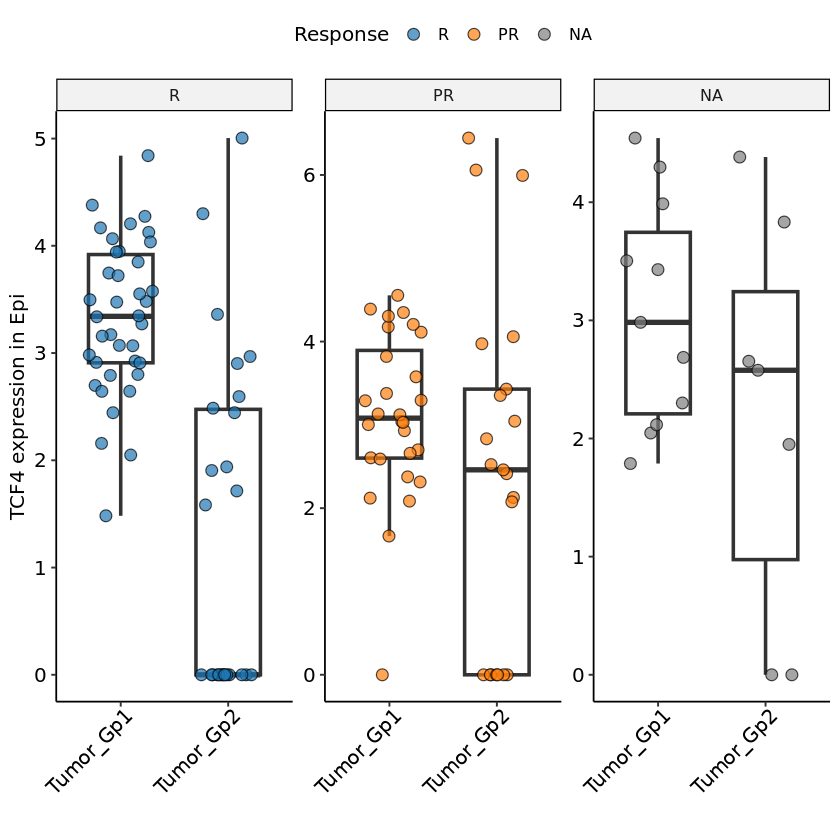

In [58]:
exprs %>% 
filter(cellgp %in% c('Tumor_Gp1', 'Tumor_Gp2')) %>% 
cell_comp_boxplot(x = 'cellgp', y = 'logcpm', pt_fill = gp, facet_by = gp, pair_by = NULL,
                  xorder = c('Tumor_Gp1', 'Tumor_Gp2'), fill_order = gp_lvls[[gp]]) +
labs(y = 'TCF4 expression in Epi', fill = 'Response')

2024-02-23 22:51:50 INFO::these clinial info will be added: response


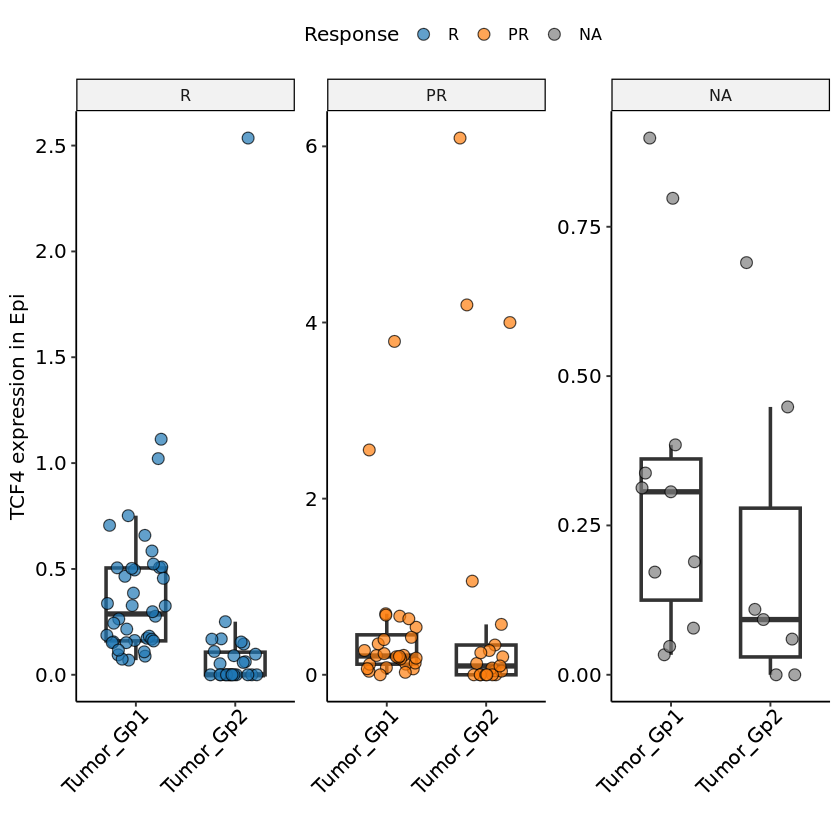

In [59]:
AverageExpression(scrna, slot = 'data', features = genes, group.by = c('sample', 'cellgp'))[['RNA']] %>% 
    as.data.frame() %>% 
pivot_longer(starts_with('P'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', regex = '(.+?)-(.+?)_(.+)', into = c('patient', 'sample_type', 'cellgp'), remove = F) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>% 
filter(cellgp %in% c('Tumor_Gp1', 'Tumor_Gp2')) %>% 
cell_comp_boxplot(x = 'cellgp', y = 'logcpm', pt_fill = gp, facet_by = gp, pair_by = NULL,
                  xorder = c('Tumor_Gp1', 'Tumor_Gp2'), fill_order = gp_lvls[[gp]]) +
labs(y = 'TCF4 expression in Epi', fill = 'Response')

In [65]:
scrna@meta.data %>% 
    count(patient, mandard_group) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>% 
    count(.data[[gp]], mandard_group)

2024-02-23 22:53:28 INFO::these clinial info will be added: response


response,mandard_group,n
<chr>,<chr>,<int>
PR,poor,16
R,good,25
NA,Out,6
NA,NA,5


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


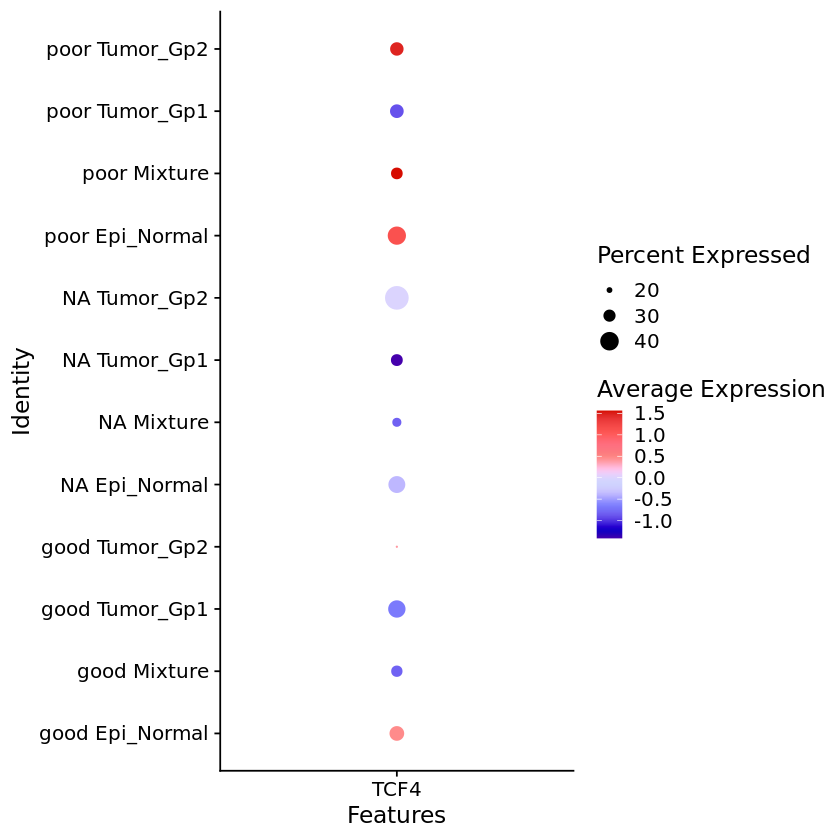

In [68]:
scrna$mandard_group[scrna$mandard_group == 'Out'] <- NA
scrna$gp <- paste(scrna$mandard_group, scrna$cellgp)
DotPlot(object = scrna, features = genes, group.by = 'gp') +
scale_color_gsea()

In [ ]:
AverageExpression(scrna, slot = 'data', features = genes, group.by = 'gp')[['RNA']] %>% 
    as.data.frame() 

good Epi_Normal,good Mixture,good Tumor_Gp1,good Tumor_Gp2,NA Epi_Normal,NA Mixture,NA Tumor_Gp1,NA Tumor_Gp2,poor Epi_Normal,poor Mixture,poor Tumor_Gp1,poor Tumor_Gp2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5694111,0.3964498,0.4148648,0.5593576,0.4551194,0.3958155,0.3163904,0.504915,0.6574606,0.716883,0.3856105,0.7056595


In [76]:
AverageExpression(scrna, slot = 'data', features = genes, group.by = c('sample', 'cellgp'))[['RNA']] %>% 
    as.data.frame() %>% 
pivot_longer(starts_with('P'), names_to = 'sample', values_to = 'logcpm') %>% 
extract(col = 'sample', regex = '(.+?)-(.+?)_(.+)', into = c('patient', 'sample_type', 'cellgp'), remove = F) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>% 
filter(cellgp %in% c('Tumor_Gp1', 'Tumor_Gp2'))

2024-02-23 23:45:00 INFO::these clinial info will be added: response


patient,response,sample,sample_type,cellgp,logcpm
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
P01,R,P01-Baseline_Tumor_Gp1,Baseline,Tumor_Gp1,0.50652101
P01,R,P01-Baseline_Tumor_Gp2,Baseline,Tumor_Gp2,0.16973998
P01,R,P01-Treat_Tumor_Gp1,Treat,Tumor_Gp1,0.75161838
P02,NA,P02-Baseline_Tumor_Gp1,Baseline,Tumor_Gp1,0.38492308
P02,NA,P02-Baseline_Tumor_Gp2,Baseline,Tumor_Gp2,0.00000000
P03,PR,P03-Baseline_Tumor_Gp1,Baseline,Tumor_Gp1,0.03984813
P03,PR,P03-Baseline_Tumor_Gp2,Baseline,Tumor_Gp2,4.00000000
P03,PR,P03-Treat_Tumor_Gp1,Treat,Tumor_Gp1,0.06710821
P03,PR,P03-Treat_Tumor_Gp2,Treat,Tumor_Gp2,0.00000000


In [85]:
scrna@meta.data %>% 
    count(patient, sample_type, cellgp) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>% 
    filter(cellgp %in% c('Tumor_Gp1', 'Tumor_Gp2')) %>% 
    arrange(.data[[gp]], cellgp, -n) %>% 
    group_by(.data[[gp]], cellgp) %>% 
    top_n(5)

2024-02-23 23:51:00 INFO::these clinial info will be added: response


Selecting by n


patient,response,sample_type,cellgp,n
<chr>,<chr>,<chr>,<chr>,<int>
P09,PR,Treat,Tumor_Gp1,1790
P07,PR,Treat,Tumor_Gp1,1310
P24,PR,Treat,Tumor_Gp1,1074
P50,PR,Baseline,Tumor_Gp1,879
P48,PR,Treat,Tumor_Gp1,693
P31,PR,Baseline,Tumor_Gp2,7715
P17,PR,Treat,Tumor_Gp2,4067
P49,PR,Baseline,Tumor_Gp2,1701
P04,PR,Baseline,Tumor_Gp2,803


# previous fig2

## pbulk expresion in Treg

- treg activation genes
- 2024-01-02: update gene list (rm TNFRSF18, IL7R)

In [178]:
f_t_obj <- '../../stage4/a01_data/seuobj/t.rds'
f_pat_gp <- '../../stage4/a19_poor_gp/redefine_gp/pateint_info-poor_redefine-v3-with_clin.tsv'
valid_types <- c('Treg_LTB', 'Treg_TNFRSF4')
genes <- c('CTLA4', 'FOXP3', 'IL2RA', 'LAG3')

min_cell <- 50  # min cell per sample

In [179]:
# obtain data
scrna <- readRDS(f_t_obj) %>% 
    subset(subset = subtype %in% valid_types)

In [180]:
# cal expression
exprs <- AggregateExpression(scrna, slot = 'counts', group.by = c('sample'))[['RNA']] %>% 
    as.data.frame() %>%
    mutate(across(everything(), ~ log1p(1e6*.x/sum(.x)))) %>% 
    rownames_to_column('symbol') %>% 
    select(symbol, starts_with('P')) %>% 
    filter(symbol %in% genes) %>%
    pivot_longer(starts_with('P'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', regex = '(.+)-(.+)', into = c('patient', 'sample_type'), remove = F) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')

2024-01-02 17:02:50 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2


In [181]:
# add cell count info
df <- scrna@meta.data %>% 
    count(sample, name = 'n_cell_per_sample') %>% 
    merge(exprs, by = 'sample')
df %>% dim
df %>% write_tsv(str_glue('{outdir}/fig2-pbulk_exprs-treg_activation-in_treg.tsv'))

[1] 324  12

In [182]:
# plot
df <- read_tsv(str_glue('{outdir}/fig2-pbulk_exprs-treg_activation-in_treg.tsv'), show_col_types = F)
gp <- 'patient_gp_v2'
for (suf in c('all', str_glue('min{min_cell}'))){
    if (suf == 'all') {
        dp <- df
    } else {
        dp <- filter(df, n_cell_per_sample >= min_cell)
    }
    loginfo('%s: %g samples', suf, length(unique(dp$sample)))
    p <- dp %>%
        filter(!is.na(.data[[gp]]), .data[[gp]] != 'poor') %>%
        cell_comp_boxplot(x = c(gp, 'sample_type'), xorder = NULL, y = 'logcpm', pt_fill = gp,
                          fill_order = gp_lvls[[gp]], facet_by = 'symbol', ncol = 7, xangle = 60) +
        stat_compare_means(comparisons = gp_comp_map[[gp]]) +
        labs(y = 'Expression in Treg', fill = 'Detailed response')
    ggsave(filename = str_glue('{outdir}/fig2-box_exprs-treg_activation_in_treg-{gp}-{suf}.pdf'),
           plot= p, width = 10, height = 6)
}

2024-01-02 17:02:50 INFO::all: 81 samples
2024-01-02 17:02:51 INFO::min50: 73 samples


## communication of EK/HK-immune, good vs poor

- date: 2023-12-29

In [ ]:
valid_ids <- c(
    'Epi_M_HK->Mye_T_Mix:MIF_CD74_CD44', 'Epi_M_HK->Mye_LILRA4:MIF_CD74_CXCR4', 'Epi_M_HK->Mye_LILRA4:MIF_CD74_CXCR4',
    'Epi_M_HK->Mye_FCN1:MIF_CD74_CD44', 'Epi_M_HK->Mye_CLEC10A:MIF_CD74_CXCR4', 'Epi_M_HK->Mye_CLEC10A:MIF_CD74_CD44',
    'Epi_M_HK->Mp_C1QA:MIF_CD74_CD44', 'Epi_M_HK->CD8_IFIT1:MIF_CD74_CXCR4', 'Epi_M_HK->CD8_GZMK:MIF_CD74_CXCR4',
    'Epi_M_HK->CD8_CX3CR1:MIF_CD74_CXCR4', 'Epi_M_HK->CD8_CCL5:MIF_CD74_CXCR4', 'Epi_M_HK->B_HLA-DRA:MIF_CD74_CXCR4',
    'Epi_M_EK->Treg:MIF_CD74_CXCR4', 'Epi_M_EK->T_Prolif:MIF_CD74_CXCR4', 'Epi_M_EK->Plasma_RRM2:MIF_CD74_CXCR4',
    'Epi_M_EK->Plasma_CXCL8:MIF_CD74_CXCR4', 'Epi_M_EK->Mye_CLEC10A:MIF_CD74_CXCR4', 'Epi_M_EK->Mp_C1QA:MIF_CD74_CD44',
    'Epi_M_EK->B_RGS13:MIF_CD74_CXCR4', 'B_RGS13->Epi_M_EK:PPIA_BSG', 'Epi_M_EK->B_T_Mix:MIF_CD74_CXCR4'
)
f_comm_info <- '../../stage4/a21_cell_comm/treg/analysis/ek_hk_immune/interaction_filter-stat-mandard_group.tsv'
gp <- 'mandard_group'

In [ ]:
p <- read_tsv(f_comm_info, show_col_types = F) %>%
    filter(id %in% valid_ids) %>%
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    unite(col = 'xlab', .data[[gp]], sample_type, sep = '-', remove = F) %>%
    mutate(xlab = factor(xlab, levels = sort(unique(xlab)))) %>% 
    mutate(id = factor(id, sort(unique(id)))) %>%
    ggdotchart(x = 'xlab', y = 'id', color = 'prob_mean', size = 'samp_pct', sorting = 'none') +
    scale_color_gsea() +
    labs(x = '', y = '', size = 'sample percent') +
    theme(axis.text.x = element_text(angle = 90, hjust = 0.9, vjust = 0.9),
          legend.position="right", legend.direction="vertical")
ggsave(filename = str_glue('{outdir}/fig2-ek_hk_immune_comm.pdf'), plot = p, width = 7, height = 9)